# How to size your bets - The Kelly Rule

he Kelly rule has a long history in gambling because it provides guidance on how much to stake on each of an (infinite) sequence of bets with varying (but favorable) odds to maximize terminal wealth. It was published as A New Interpretation of the Information Rate in 1956 by John Kelly who was a colleague of Claude Shannon's at Bell Labs. He was intrigued by bets placed on candidates at the new quiz show The $64,000 Question, where a viewer on the west coast used the three-hour delay to obtain insider information about the winners. 

Kelly drew a connection to Shannon's information theory to solve for the bet that is optimal for long-term capital growth when the odds are favorable, but uncertainty remains. His rule maximizes logarithmic wealth as a function of the odds of success of each game, and includes implicit bankruptcy protection since log(0) is negative infinity so that a Kelly gambler would naturally avoid losing everything.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
%pip install --quiet scipy sympy seaborn
import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Alex\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
DATA_STORE = Path('..', 'data', 'assets.h5')

## The optimal size of a bet

Kelly began by analyzing games with a binary win-lose outcome. The key variables are:
- b: The odds define the amount won for a \\$1 bet. Odds = 5/1 implies a \\$5 gain if the bet wins, plus recovery of the \\$1 capital.
- p: The probability defines the likelihood of a favorable outcome.
- f: The share of the current capital to bet.
- V: The value of the capital as a result of betting.

The Kelly rule aims to maximize the value's growth rate, G, of infinitely-repeated bets (see Chapter 5 for background).
$$G=\lim_{N\rightarrow\infty}=\frac{1}{N}\log\frac{V_N}{V_0}$$

Proof for the above formula: 
after many bets we would have 
$$V_N = V_0 * (X_1 .... X_n)$$ where $$X_i$$ is either $$(1 + bf)$$ or $$(1-f)$$

take log on both sides gives us 
$$ \log{V_n} = \log{V_0} + \sum_{i=1}^N\log{X_i} $$

the growth rate is: 
$$ \frac{\log{V_n} - \log{V_0}}{N} = \frac{1}{N} * \sum_{i=1}^N\log{X_i}  $$

as N approaches infinity we want to compute 

$$G=\lim_{N\rightarrow\infty}=\frac{1}{N}\log\frac{V_N}{V_0}$$


# Step 1 — Define wealth after one bet

$$
V_1 =
\begin{cases}
V_0(1 + bf), & \text{win} \\
V_0(1 - f), & \text{loss}
\end{cases}
$$

---

# Step 2 — Compute expected growth rate

$$
G(f) = p\log(1 + bf) + (1 - p)\log(1 - f)
$$

---

# Step 3 — Maximize \(G(f)\) using calculus

If you take the derivative and set it to zero, you get:

$$
f = \frac{bp - (1 - p)}{b}
$$

which simplifies to the familiar:

$$
f= \frac{bp - q}{b}
$$


We can maximize the rate of growth G by maximizing G with respect to f, as illustrated using sympy as follows:

In [6]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share) # Kelly formula as written as p * (1 + bf) + (1 - p) * (1 - f)
solve(diff(Value, share), share) # gets the optimal share

[(odds*probability + probability - 1)/odds]

In [7]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f) # f is the fraction to bet
solve(diff(y, f), f)

[2*p - 1]

## Get S&P 500 Data

In [10]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/fred'].close

### Compute Returns & Standard Deviation

In [11]:
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500') # get annual returns 

In [13]:
annual_returns

,sp500
DATE,
2016-12-31,0.095350
2017-12-31,0.194200
2018-12-31,-0.062373
2019-12-31,0.288781
2020-12-31,0.162589
2021-12-31,0.268927
2022-12-31,-0.194428
2023-12-31,0.242305
2024-12-31,0.233090


In [ ]:
return_params = annual_returns.sp500.rolling(4).agg(['mean', 'std']).dropna() # get rolling mean and std dev of returns for 4 years

In [20]:
return_params

,mean,std
DATE,,
2019-12-31,0.128989,0.150041
2020-12-31,0.145799,0.148777
2021-12-31,0.164481,0.161065
2022-12-31,0.131467,0.224217
2023-12-31,0.119848,0.214334
2024-12-31,0.137474,0.221789
2025-12-31,0.106251,0.205292


In [25]:
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2)))) # 95% confidence interval for mean return, resembles boilder bands

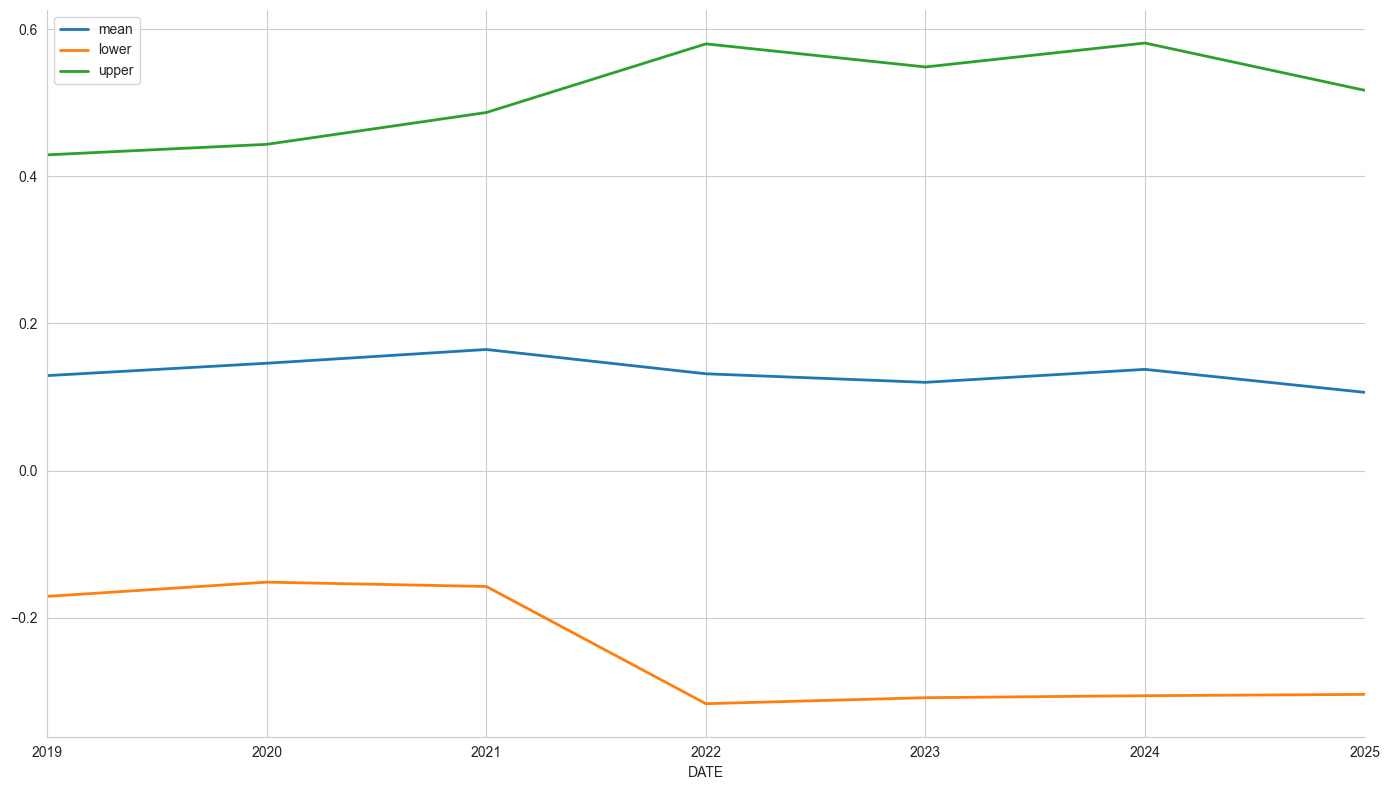

In [26]:
return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

### Kelly Rule for a Single Asset - Index Returns

In a financial market context, both outcomes and alternatives are more complex, but the Kelly rule logic does still apply. It was made popular by Ed Thorp, who first applied it profitably to gambling (described in Beat the Dealer) and later started the successful hedge fund Princeton/Newport Partners.

With continuous outcomes, the growth rate of capital is defined by an intergral over the probability distribution of the different returns that can be optimized numerically.
We can solve this expression (see book) for the optimal f* using the `scipy.optimize` module:

binary kelly is easy, we have done it above , financial returns are not binary, they are continuous, instead of win or lose, we have real numbers. 


In [ ]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std), 
                               mean - 3 * std, 
                               mean + 3 * std) # f is the fraction to bet, s is the return, probability of that outcome is normal distribution with mean and std dev
    return -val # return negative for minimization, returns a scalar value 

In [42]:
def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), mean-3*std, mean+3*std)
    return val

In [ ]:
def get_kelly_share(data):
    solution = minimize_scalar(norm_integral, 
                        args=(data['mean'], data['std']), # things to pass to norm_integral, f is not passed here, it is the variable to optimize
                        bounds=[0, 2], # fractions between 0 and 2
                        method='bounded') 
    return solution.x # this is doing argmax(f) of the integral(expected log return) above

In [30]:
return_params # this is return mean and std dev over 4 year rolling window

,mean,std
DATE,,
2019-12-31,0.128989,0.150041
2020-12-31,0.145799,0.148777
2021-12-31,0.164481,0.161065
2022-12-31,0.131467,0.224217
2023-12-31,0.119848,0.214334
2024-12-31,0.137474,0.221789
2025-12-31,0.106251,0.205292


In [31]:
annual_returns['f'] = return_params.apply(get_kelly_share, axis=1) # over each row, get kelly share based on mean and std dev of returns, find f that maximizes expected log return

In [ ]:
annual_returns["f"] # optimal fraction to invest in sp500 each year based on kelly criterion

DATE
2016-12-31         NaN
2017-12-31         NaN
2018-12-31         NaN
2019-12-31    1.999996
2020-12-31    1.999996
2021-12-31    1.999996
2022-12-31    1.846436
2023-12-31    1.907718
2024-12-31    1.893930
2025-12-31    1.947372
Freq: A-DEC, Name: f, dtype: float64

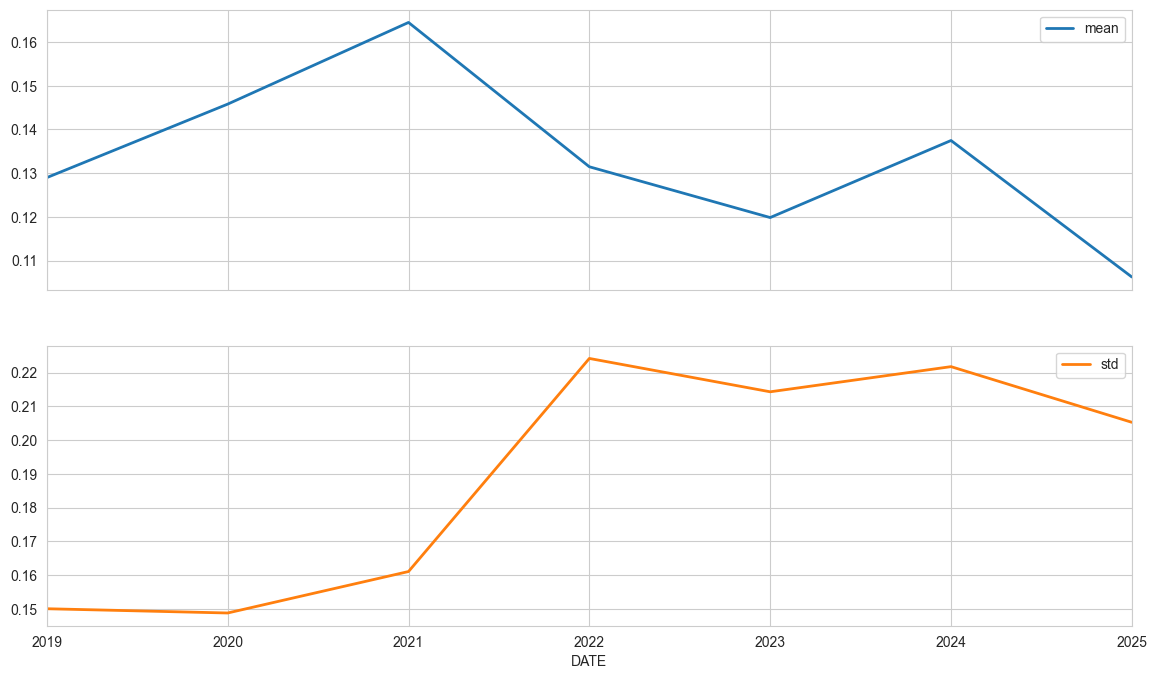

In [33]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [34]:
annual_returns.tail()

,sp500,f
DATE,,
2021-12-31,0.268927,1.999996
2022-12-31,-0.194428,1.846436
2023-12-31,0.242305,1.907718
2024-12-31,0.233090,1.893930
2025-12-31,0.144037,1.947372


### Performance Evaluation

In [ ]:
annual_returns # each f is computed based on prior 4 years of returns INCLUDING that year 
# sp500 column represents return for that year

,sp500,f
DATE,,
2016-12-31,0.095350,NaN
2017-12-31,0.194200,NaN
2018-12-31,-0.062373,NaN
2019-12-31,0.288781,1.999996
2020-12-31,0.162589,1.999996
2021-12-31,0.268927,1.999996
2022-12-31,-0.194428,1.846436
2023-12-31,0.242305,1.907718
2024-12-31,0.233090,1.893930


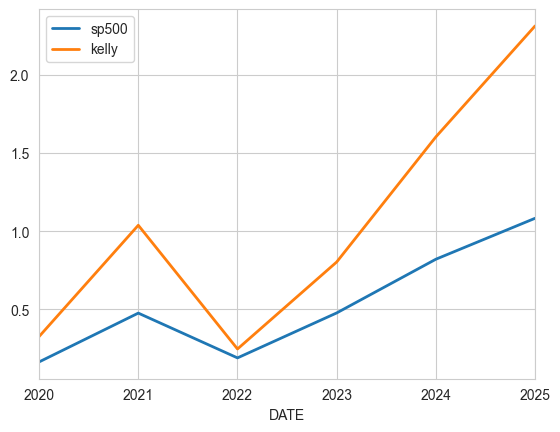

In [ ]:
(annual_returns[['sp500']]
 .assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift())) # return for that year * fraction invested in previous year
 .dropna() # .assign is bascially annual_returns['kelly'] = ...
 .loc['2016':]
 .add(1) # convert to growth factor
 .cumprod() # cumulative product to get growth of $1 invested
 .sub(1) # convert back to return
 .plot(lw=2)); # plots each column as a line


In [37]:
annual_returns.f.describe()

count    7.000000
mean     1.942206
std      0.061560
min      1.846436
25%      1.900824
50%      1.947372
75%      1.999996
max      1.999996
Name: f, dtype: float64

In [38]:
return_ci.head()

,mean,lower,upper
DATE,,,
2019-12-31,0.128989,-0.171092,0.429071
2020-12-31,0.145799,-0.151755,0.443353
2021-12-31,0.164481,-0.157648,0.486611
2022-12-31,0.131467,-0.316966,0.579900
2023-12-31,0.119848,-0.308819,0.548516


### Compute Kelly Fraction

In [39]:
m = .058
s = .216

In [40]:
# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

Optimal Kelly fraction: 1.1974


In [43]:
# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))

Optimal Kelly fraction: 1.1974


## Kelly Rule for Multiple Assets

We will use an example with various equities. [E. Chan (2008)](https://www.amazon.com/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889) illustrates how to arrive at a multi-asset application of the Kelly Rule, and that the result is equivalent to the (potentially levered) maximum Sharpe ratio portfolio from the mean-variance optimization. 

The computation involves the dot product of the precision matrix, which is the inverse of the covariance matrix, and the return matrix:

In [50]:
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter( items=sp500_stocks)

In [53]:
len(prices.columns)

433

In [56]:
len(sp500_stocks)

503

In [58]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 181 entries, MMM to XEL
dtypes: float64(181)
memory usage: 510.5 KB


### Compute Precision Matrix

In [59]:
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)

In [60]:
kelly_allocation = monthly_returns.mean().dot(precision_matrix)

In [63]:
kelly_allocation

ticker
MMM     4.228376
AOS     2.571095
ABT    -0.002867
ADBE    0.060845
AMD    -0.423187
          ...   
WST    -0.085159
WDC     0.059327
WY     -3.143547
WMB    -2.445971
XEL    -5.440800
Length: 181, dtype: float64

In [64]:
kelly_allocation.describe()

count    181.000000
mean       0.255103
std        3.055239
min       -7.836244
25%       -1.539977
50%       -0.002867
75%        2.158994
max       10.559607
dtype: float64

In [65]:
kelly_allocation.sum()

46.17361459275996

### Largest Portfolio Allocation

The plot shows the tickers that receive an allocation weight > 5x their value:

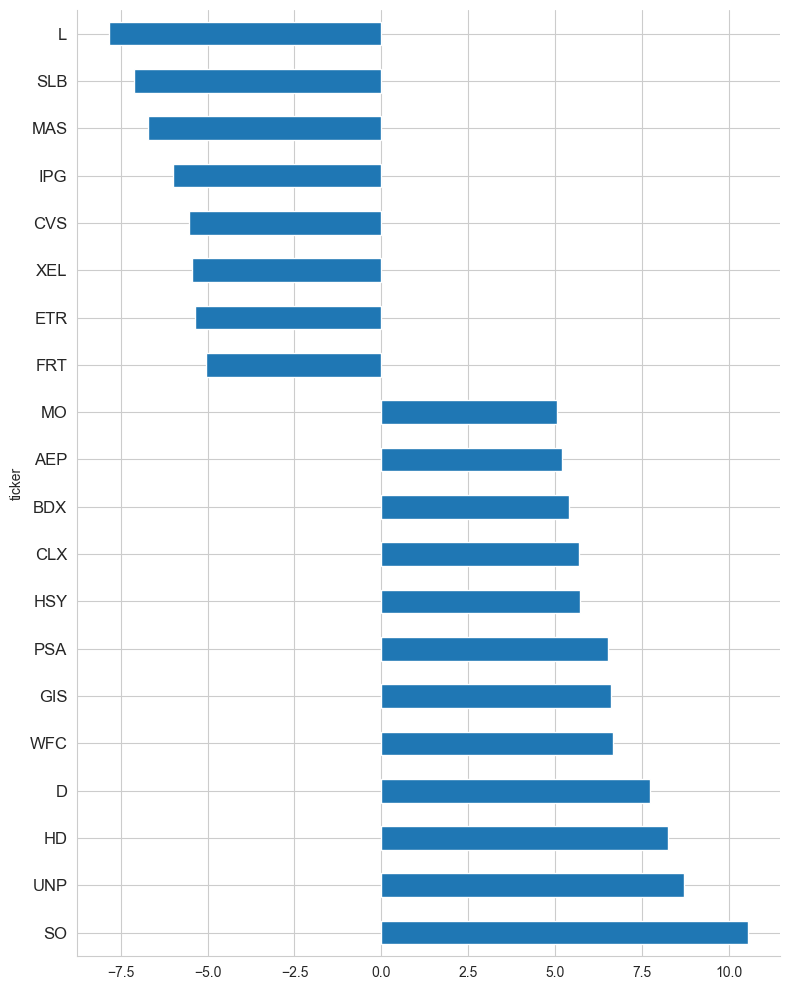

In [66]:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

### Performance vs SP500

The Kelly rule does really well. But it has also been computed from historical data..

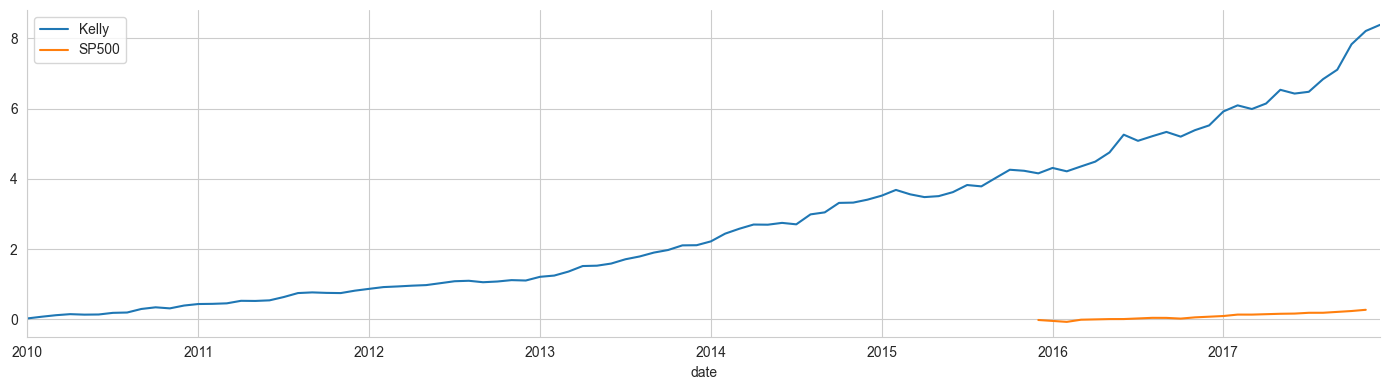

In [67]:
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();